In [1]:
import numpy as np
from keras.datasets import cifar10  # ラベル付けされた5万枚の訓練画像と1万枚のテスト画像のデータセットが入ってます。

from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

# from keras.utils import np_utils
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


👆ニューラルネットワークの層を作るため、必要な関数を取り込んでおきます。

In [2]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

👆cifar10から画像を取り入れます。下記の正解レベルがあります。
0-airplane 1-automobile 2-bird 3-cat 4-deer 5-dog 6-frog 7-horse 8-ship 9-ship
(x_train: 訓練画像, y_train: x_trainに対応する答え, x_test: テスト画像, y_test: x_testに対応する答え)

In [3]:
import matplotlib.pyplot as plt  # 画像を描画するツール
%matplotlib inline

👆このエディタ(jupyter notebook)に表示させるためのコマンドです。

/Users/takanoreimi/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


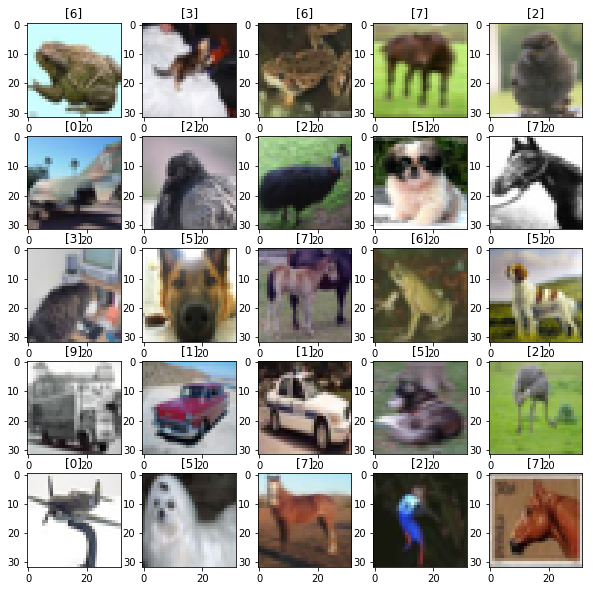

In [4]:
#5x5枚の画像を表示する
plt.figure(figsize=(10,10))
for i in range(25):
    rand_num=np.random.randint(0,50000)
    cifar_img=plt.subplot(5,5,i+1)
    plt.imshow(x_train[rand_num])
    #x軸の目盛りを消す
    #plt.tick_params(labelbottom='off')
    #y軸の目盛りを消す
    #plt.tick_params(labelleft='off')
    #正解ラベルを表示
    plt.title(y_train[rand_num])
plt.show()

5万枚の訓練データの中からランダムに25枚選び表示してみました。

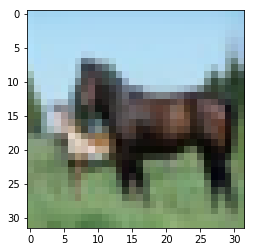

In [5]:
plt.imshow(x_train[12])

訓練データ12番目の画像はこんな感じです。

In [6]:
y_train[12]  # 1枚目を表示してみる

array([7], dtype=uint8)

訓練データの12番目の答えはこんな情報でした。7のhorseのようです。

In [7]:
#x_train=x_train.astype('float32')/255.0
#x_test=x_test.astype('float32')/255.0
x_train = x_train/255.0
x_test = x_test/255.0

縦横32x32、0-255のRGBなので255で割って0-1で正規化します。（精度を上げるため。）

In [8]:
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


In [9]:
# y_train=np_utils.to_categorical(y_train,10)
# y_test=np_utils.to_categorical(y_test,10)
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

👆正解ラベルをOne-Hot表現（１次元の行列）に変換しておきます。

In [10]:
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1, 10)


訓練データの情報を表示してみました。50000万枚の縦×横が (32,32) の画像です。対応する答えも50000個で、10種類です。

In [11]:
y_train[12]  # 1枚目を表示してみる

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

訓練データの答えを見てみると、こんな情報でした。「7」のhorseになってます。

In [12]:
input_shape = (32, 32, 3)
num_classes = 10

👆入れるデータは32×32、3チャンネルの情報として、答えは0-9の10種類（クラス）と設定します。

In [13]:
x_in = Input(shape=input_shape, name='input')
x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal')(x_in)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(64, activation='relu')(x)
#x = Dropout(0.25)(x)
prediction = Dense(num_classes, activation='softmax', name='prediction')(x)
model = Model(x_in, prediction)
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='sgd')

👆答えの予測方法を設定します。（前回のCNN同様の２段階のフィルタと情報選択と、過学習を避けるために出力結果を間引いて答えを決めることにします。）

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
__________

今の設定を表示しておきました。

In [15]:
callbacks = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, epochs=100, batch_size=128, callbacks=[callbacks], validation_data=(x_test, y_test))

ValueError: Error when checking target: expected prediction to have 2 dimensions, but got array with shape (50000, 1, 10)

val_lossが飽和した時に、10回最大値が更新されなかったら止める

👆「50000個の教師データで学び、10000個のデータから128個選んでテストしてみる」という学習を10回繰り返します。毎回、正解率（Accuracy)と真値との誤差の指標（Loss)を表示しています。（「正確さ（Accuracy）」が１に近づくように、学習していきます。）

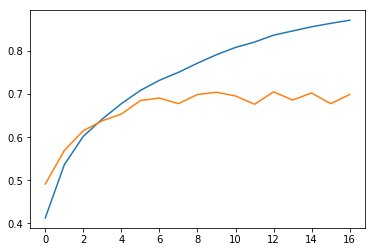

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

学習の成果を表示しました。青は教師データでの学習結果、オレンジはテストの結果です。学習するに従って正確に手書きの文字を認識できるようになっています。